# Imports

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline # Used to smoothen out data
import statsmodels.api as sm # Used later to estimate a team's "quality"
import matplotlib.pyplot as plt

# Reading in csvs

In [2]:
MRegularSeasonCompactResults = pd.read_csv('../../data/MRegularSeasonCompactResults.csv')
WRegularSeasonCompactResults = pd.read_csv('../../data/WRegularSeasonCompactResults.csv')
MRegularSeasonDetailedResults = pd.read_csv('../../data/MRegularSeasonDetailedResults.csv')
WRegularSeasonDetailedResults = pd.read_csv('../../data/WRegularSeasonDetailedResults.csv')
MNCAATourneyCompactResults = pd.read_csv('../../data/MNCAATourneyCompactResults.csv')
WNCAATourneyCompactResults = pd.read_csv('../../data/WNCAATourneyCompactResults.csv')
MNCAATourneyDetailedResults = pd.read_csv('../../data/MNCAATourneyDetailedResults.csv') 
WNCAATourneyDetailedResults = pd.read_csv('../../data/WNCAATourneyDetailedResults.csv')
MNCAATourneySeeds = pd.read_csv('../../data/MNCAATourneySeeds.csv')
WNCAATourneySeeds = pd.read_csv('../../data/WNCAATourneySeeds.csv')
MGameCities = pd.read_csv('../../data/MGameCities.csv') 
WGameCities = pd.read_csv('../../data/WGameCities.csv')
MSeasons = pd.read_csv('../../data/MSeasons.csv') 
WSeasons = pd.read_csv('../../data/WSeasons.csv')

# Combining men and women datasets

In [3]:
tourney_results = pd.concat([
    MNCAATourneyDetailedResults, WNCAATourneyDetailedResults
], ignore_index=True)

seeds = pd.concat([
    MNCAATourneySeeds, WNCAATourneySeeds
], ignore_index=True)

regular_results = pd.concat([
    MRegularSeasonDetailedResults, WRegularSeasonDetailedResults
], ignore_index=True)

## Making every game appear twice (from both winner and loser's perspective)

#### Also "one-hot encodes" location (1 = home, -1 = away, 0 = neutral)

In [4]:
def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    
    return output

In [5]:
regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

# Feature selection

# BETTER FEATURE ENGINEERING??

In [6]:
features = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff']

# Computing season averages for each feature in the above array (grouped by season & teamID)

#### Also replacing "T2" with "Opponent" and "T1" with an empty string

In [7]:
funcs = [np.mean]

season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[features].agg(funcs).reset_index()

season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]

season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

/var/folders/fg/_cm9z0lx34b9zrpmj_h8s3q80000gn/T/ipykernel_16550/4129688711.py:3: FutureWarning: The provided callable <function mean at 0x107979da0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[features].agg(funcs).reset_index()


In [8]:
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]

tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

# Win ratio for every team in the last 14 days of the regular season. 

# CHANGE TO LESS RECENT (20 days, 30 days, etc)??

# TRY FULL SEASON

In [9]:
last30days_stats_T1 = regular_data.loc[regular_data.DayNum>102].reset_index(drop=True)
last30days_stats_T1['win'] = np.where(last30days_stats_T1['PointDiff']>0,1,0)
last30days_stats_T1 = last30days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_30d')

last30days_stats_T2 = regular_data.loc[regular_data.DayNum>102].reset_index(drop=True)
last30days_stats_T2['win'] = np.where(last30days_stats_T2['PointDiff']<0,1,0)
last30days_stats_T2 = last30days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_30d')


In [10]:
tourney_data = pd.merge(tourney_data, last30days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, last30days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [11]:
regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])

# Using a logistic regression model to classify teams based on "quality"

In [12]:
def team_quality(season):
    formula = 'win~-1+T1_TeamID+T2_TeamID'
    glm = sm.GLM.from_formula(formula=formula, 
                              data=regular_season_effects.loc[regular_season_effects.Season==season,:], 
                              family=sm.families.Binomial()).fit()
    
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ['TeamID','quality']
    quality['Season'] = season
    quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
    quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)
    return quality


In [13]:
formula = 'win~-1+T1_TeamID+T2_TeamID'
glm = sm.GLM.from_formula(formula=formula, 
                          data=regular_season_effects.loc[regular_season_effects.Season==2010,:], 
                          family=sm.families.Binomial()).fit()

quality = pd.DataFrame(glm.params).reset_index()

glm_quality = pd.concat([team_quality(2010),
                         team_quality(2011),
                         team_quality(2012),
                         team_quality(2013),
                         team_quality(2014),
                         team_quality(2015),
                         team_quality(2016),
                         team_quality(2017),
                         team_quality(2018),
                         team_quality(2019),
                         ##team_quality(2020),
                         team_quality(2021),
                         team_quality(2022),
                         team_quality(2023)
                         ]).reset_index(drop=True)

/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:198: Runti

In [14]:
glm_quality_T1 = glm_quality.copy()
glm_quality_T2 = glm_quality.copy()
glm_quality_T1.columns = ['T1_TeamID','T1_quality','Season']
glm_quality_T2.columns = ['T2_TeamID','T2_quality','Season']

# Adding team quality to each team in the tournament data frame

In [15]:
tourney_data = pd.merge(tourney_data, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [16]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))

seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]

# 45 features ---> definitely need to feature engineer

In [17]:
features = list(season_statistics_T1.columns[2:999]) + \
    list(season_statistics_T2.columns[2:999]) + \
    list(seeds_T1.columns[2:999]) + \
    list(seeds_T2.columns[2:999]) + \
    list(last30days_stats_T1.columns[2:999]) + \
    list(last30days_stats_T2.columns[2:999]) + \
    ["Seed_diff"] + ["T1_quality","T2_quality"]

print(len(features))
print(features[:10])

45
['T1_FGMmean', 'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean', 'T1_ORmean', 'T1_Astmean', 'T1_TOmean', 'T1_Stlmean', 'T1_PFmean', 'T1_opponent_FGMmean']


# REMOVING SEED DIFFERENCE FOR THIS RUN

In [18]:
features = (
    list(season_statistics_T1.columns[2:]) + 
    list(season_statistics_T2.columns[2:]) + 
    list(seeds_T1.columns[2:]) + 
    list(seeds_T2.columns[2:]) + 
    list(last30days_stats_T1.columns[2:]) + 
    list(last30days_stats_T2.columns[2:]) + 
    # ["Seed_diff"] + 
    ["T1_quality", "T2_quality"]
)

# What the features look like in the dataset

In [19]:
display(tourney_data[features].head(10))
print("\nfeatures shape:", tourney_data[features].shape)

,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,...,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_seed,T2_seed,T1_win_ratio_30d,T2_win_ratio_30d,T1_quality,T2_quality
0,24.379310,56.793103,6.482759,18.000000,12.275862,13.034483,16.206897,7.068966,19.103448,27.793103,...,14.333333,8.000000,2.600000,1.966667,16,16,0.428571,0.454545,NaN,NaN
1,30.321429,65.714286,7.035714,20.071429,15.178571,17.642857,14.785714,8.464286,17.750000,26.357143,...,13.000000,7.103448,3.655172,4.655172,1,16,0.857143,0.750000,NaN,NaN
2,27.206897,56.896552,4.000000,12.586207,13.689655,15.551724,14.000000,5.206897,19.413793,24.793103,...,15.068966,7.275862,3.172414,8.689655,10,7,0.428571,0.888889,NaN,NaN
3,26.620690,52.689655,6.827586,17.931034,10.586207,15.620690,18.241379,7.103448,20.965517,26.344828,...,17.060606,6.333333,2.575758,14.909091,11,6,0.900000,0.777778,NaN,NaN
4,27.344828,58.724138,6.413793,17.034483,11.241379,16.000000,14.172414,6.551724,17.103448,25.379310,...,14.633333,7.433333,2.833333,4.400000,8,9,0.500000,0.500000,NaN,NaN
5,29.533333,62.200000,6.066667,15.700000,14.766667,15.633333,15.800000,5.933333,18.400000,24.866667,...,14.483871,5.483871,2.225806,8.774194,5,12,0.600000,0.750000,NaN,NaN
6,27.366667,60.333333,7.333333,20.600000,13.766667,13.833333,14.033333,8.500000,21.266667,25.066667,...,12.233333,9.033333,3.066667,1.333333,3,14,0.800000,0.500000,NaN,NaN
7,26.064516,55.451613,7.161290,19.064516,11.935484,15.741935,14.548387,6.806452,18.645161,23.903226,...,13.928571,4.142857,3.035714,5.821429,9,8,0.714286,0.375000,NaN,NaN
8,27.100000,55.800000,7.433333,20.166667,9.733333,18.266667,13.166667,7.000000,19.133333,20.333333,...,15.741935,5.967742,2.548387,6.677419,4,13,0.800000,1.000000,NaN,NaN
9,30.233333,62.300000,4.800000,14.133333,14.300000,16.733333,14.900000,10.133333,16.700000,24.600000,...,12.366667,5.000000,2.100000,5.866667,2,15,0.777778,0.777778,NaN,NaN



features shape: (4552, 44)


# Target variable = score difference; features = features from above

In [20]:
y = tourney_data['T1_Score'] - tourney_data['T2_Score']

X = tourney_data[features].values
dtrain = xgb.DMatrix(X, label = y)

# Standardizing input features

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
dtrain = xgb.DMatrix(X_scaled, label=y)

# Loss function (cauchy object)

In [22]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

# Loss function (huber loss)

In [23]:
def huberobj(preds, dtrain):
    labels = dtrain.get_label()
    delta = 1.0  # You can tune this parameter
    x = preds - labels
    grad = np.where(np.abs(x) <= delta, x, delta * np.sign(x))
    hess = np.where(np.abs(x) <= delta, 1, 0)
    return grad, hess


# Model parameters (learning rate, tree size, etc)

# IMPROVE PARAMETERS??

In [26]:
param = {} 

param['eval_metric'] = 'mae'
param['booster'] = 'dart'  # Enable dropout-based boosting
param['eta'] = 0.02  # Learning rate
param['subsample'] = 0.35  # Proportion of training data used in each tree
param['colsample_bytree'] = 0.7  # Proportion of features used in each tree
param['num_parallel_tree'] = 2   # Number of trees
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] = 3
param['silent'] = 0  # Keep logs visible
param['tree_method'] = 'hist' 

# Dropout-specific parameters
param['rate_drop'] = 0.1  # Probability of a tree being dropped in a boosting round
param['skip_drop'] = 0.5  # Probability of skipping dropout

# Training the model!

# ADD DROPOUT

In [27]:
xgb_cv = [] ## storing the results of each cross-validation run 
repeat_cv = 5 # doing 10 runs of cross-validation (more/less ??)

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj, # specific loss function we defined above (change it??)
          num_boost_round = 500, # max number of rounds if early stopping doesn't stop it 
          folds = KFold(n_splits = 5, shuffle = True, random_state = i), # shuffles the data and splits it into 5 folds
          early_stopping_rounds = 50, # stops training if we don't improve for 50 rounds
          verbose_eval = 50,
          # eval_metric = 'logloss', 
          # maximize = False, 
          # threshold = 0.01 
        )
    )

Fold repeater 0
[0]	train-mae:13.57571+0.06078	test-mae:13.57804+0.23413


/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:32:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:11.22070+0.13165	test-mae:11.30866+0.16194
[100]	train-mae:10.30333+0.07381	test-mae:10.45381+0.18280
[150]	train-mae:9.83508+0.08378	test-mae:10.04990+0.18033
[200]	train-mae:9.58948+0.07908	test-mae:9.85324+0.17098
[250]	train-mae:9.43062+0.07739	test-mae:9.73490+0.17041
[300]	train-mae:9.32098+0.05609	test-mae:9.66843+0.16871
[350]	train-mae:9.24275+0.05344	test-mae:9.63177+0.16570
[400]	train-mae:9.18321+0.05412	test-mae:9.60581+0.16527
[450]	train-mae:9.12706+0.04862	test-mae:9.59053+0.16754
[499]	train-mae:9.07178+0.04614	test-mae:9.57606+0.16961
Fold repeater 1
[0]	train-mae:13.57736+0.07600	test-mae:13.58037+0.30781


/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:39:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:11.22013+0.07830	test-mae:11.30540+0.29351
[100]	train-mae:10.30021+0.04242	test-mae:10.44431+0.22641
[150]	train-mae:9.83551+0.05888	test-mae:10.03163+0.23899
[200]	train-mae:9.59234+0.06385	test-mae:9.83781+0.20769
[250]	train-mae:9.43291+0.04655	test-mae:9.71760+0.21323
[300]	train-mae:9.32179+0.03742	test-mae:9.65105+0.19821
[350]	train-mae:9.24357+0.03590	test-mae:9.61512+0.19961
[400]	train-mae:9.18030+0.03698	test-mae:9.59615+0.20400
[450]	train-mae:9.12502+0.04022	test-mae:9.57990+0.20635
[499]	train-mae:9.06756+0.04239	test-mae:9.56612+0.20772
Fold repeater 2
[0]	train-mae:13.57950+0.05841	test-mae:13.58180+0.23892


/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:46:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:11.21017+0.11660	test-mae:11.30510+0.14514
[100]	train-mae:10.29325+0.07573	test-mae:10.45187+0.07189
[150]	train-mae:9.82893+0.09115	test-mae:10.03408+0.10691
[200]	train-mae:9.58956+0.07754	test-mae:9.83297+0.13542
[250]	train-mae:9.43145+0.06853	test-mae:9.71436+0.16592
[300]	train-mae:9.32509+0.04940	test-mae:9.64583+0.18305
[350]	train-mae:9.24891+0.04931	test-mae:9.60825+0.18955
[400]	train-mae:9.18710+0.05253	test-mae:9.58808+0.18821
[450]	train-mae:9.13083+0.04854	test-mae:9.56882+0.19341
[499]	train-mae:9.07362+0.04739	test-mae:9.55507+0.19865
Fold repeater 3
[0]	train-mae:13.57616+0.09889	test-mae:13.57872+0.40056


/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:53:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:11.22259+0.12335	test-mae:11.32503+0.20086
[100]	train-mae:10.30269+0.07652	test-mae:10.47243+0.13049
[150]	train-mae:9.83482+0.10886	test-mae:10.06903+0.12053
[200]	train-mae:9.58985+0.08779	test-mae:9.85695+0.15478
[250]	train-mae:9.43298+0.09099	test-mae:9.74730+0.16182
[300]	train-mae:9.32395+0.07121	test-mae:9.67739+0.18308
[350]	train-mae:9.24732+0.06066	test-mae:9.63911+0.19357
[400]	train-mae:9.18469+0.05741	test-mae:9.61796+0.19562
[450]	train-mae:9.12844+0.05794	test-mae:9.60308+0.19742
[499]	train-mae:9.07531+0.05347	test-mae:9.59322+0.20069
Fold repeater 4
[0]	train-mae:13.57637+0.06995	test-mae:13.57798+0.27473


/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:00:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:11.22289+0.09637	test-mae:11.30000+0.29965
[100]	train-mae:10.29826+0.06206	test-mae:10.44929+0.19572
[150]	train-mae:9.82982+0.08698	test-mae:10.03791+0.10672
[200]	train-mae:9.58506+0.07225	test-mae:9.84028+0.08954
[250]	train-mae:9.42715+0.07292	test-mae:9.72605+0.06163
[300]	train-mae:9.31934+0.04705	test-mae:9.66733+0.05880
[350]	train-mae:9.24155+0.03678	test-mae:9.63091+0.05504
[400]	train-mae:9.17868+0.03552	test-mae:9.60922+0.05290
[450]	train-mae:9.12108+0.03526	test-mae:9.59463+0.05183
[499]	train-mae:9.06715+0.03006	test-mae:9.58017+0.05058


# Cross-fold visualizer

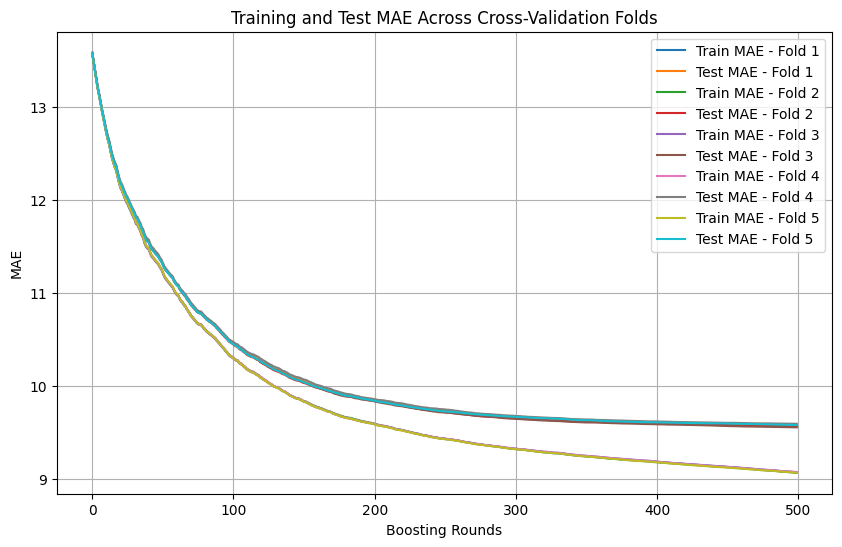

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for i in range(repeat_cv):
    plt.plot(xgb_cv[i]['train-mae-mean'], label=f'Train MAE - Fold {i+1}')
    plt.plot(xgb_cv[i]['test-mae-mean'], label=f'Test MAE - Fold {i+1}')

plt.title("Training and Test MAE Across Cross-Validation Folds")
plt.xlabel("Boosting Rounds")
plt.ylabel("MAE")
plt.legend(loc="best")
plt.grid(True)
plt.show()


# 10 most important features (definitely need to feature engineer)

/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:09:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 1000x800 with 0 Axes>

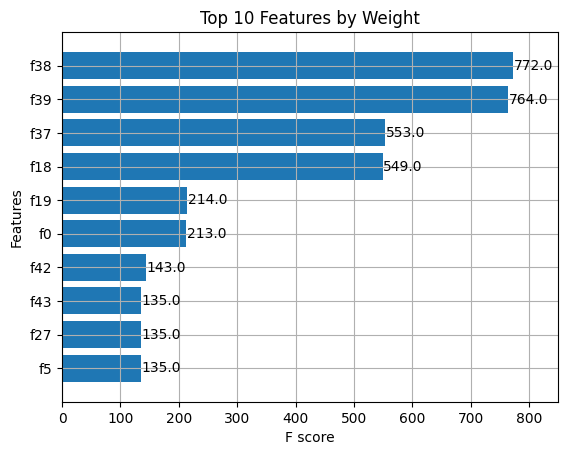

In [29]:
best_num_boost_round = xgb_cv[4].shape[0] 

model = xgb.train(param, dtrain, num_boost_round=best_num_boost_round)

# Plot feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(model, importance_type='weight', max_num_features=10, height=0.8)
plt.title("Top 10 Features by Weight")
plt.show()

In [30]:
importance = model.get_score(importance_type='weight')

sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
print("Top 10 Features by Importance:")
for feature, score in sorted_importance[:10]:
    print(f"{feature}: {score}")


Top 10 Features by Importance:
f38: 772.0
f39: 764.0
f37: 553.0
f18: 549.0
f19: 214.0
f0: 213.0
f42: 143.0
f5: 135.0
f27: 135.0
f43: 135.0


In [32]:
print("In order, the most important features are: ")
print(f"1. {features[38]}")
print(f"2. {features[39]}")
print(f"3. {features[37]}")
print(f"4. {features[18]}")
print(f"5. {features[19]}")
print(f"6. {features[0]}")
print(f"7. {features[42]}")
print(f"8. {features[5]}")
print(f"9. {features[27]}")
print(f"10. {features[43]}")

In order, the most important features are: 
1. T1_seed
2. T2_seed
3. T2_PointDiffmean
4. T1_PointDiffmean
5. T2_FGMmean
6. T1_FGMmean
7. T1_quality
8. T1_Astmean
9. T2_PFmean
10. T2_quality


# Learning curve

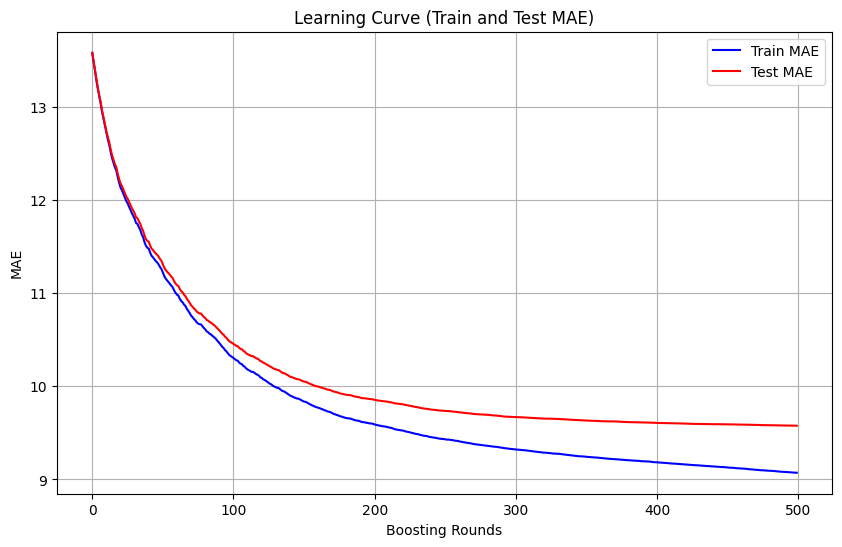

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(xgb_cv[0]['train-mae-mean'], label='Train MAE', color='blue')
plt.plot(xgb_cv[0]['test-mae-mean'], label='Test MAE', color='red')
plt.title("Learning Curve (Train and Test MAE)")
plt.xlabel("Boosting Rounds")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.show()

In [34]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]

oof_preds = []
for i in range(repeat_cv):
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))

/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:12:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/var/folders/fg/_cm9z0lx34b9zrpmj_h8s3q80000gn/T/ipykernel_16550/2329130935.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.15614605e+01  1.37265558e+01  4.47331953e+00  1.87448673e+01
  1.12013597e+01 -1.52275905e-01  9.24570179e+00 -9.88751984e+00
 -4.45473480e+00 -1.35502577e+00 -3.81546378e+00 -1.36132455e+00
  7.55700970e+00  2.36828971e+00  1.67626648e+01  4.92223787e+00
  4.51531363e+00  4.17313844e-01 -8.53367627e-01  9.00341606e+00
  1.81218853e+01 -8.74689579e-01  2.81801534e+00  2.77725201e+01
  1.02289190e+01 -1.98957431e+00  1.61812744e+01  5.72696543e+00
  1.23476925e+01  3.54028225e+00  1.43088884e+01 -2.71173596e+00
  4.222086

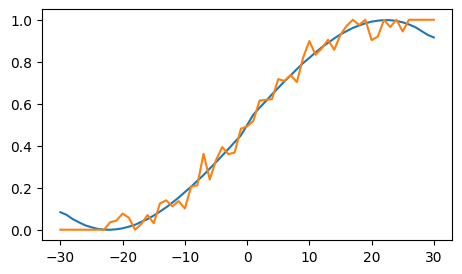

In [35]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))


plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int').mean().reset_index()

plt.figure(figsize=[5.3,3.0])
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)

# Preparing output for submission

In [37]:
sampleSub2 = pd.read_csv("../../data/SampleSubmissionStage2.csv")
print(f"sampleSub2.shape: {sampleSub2.shape}")

sampleSub2['Season'] = sampleSub2['ID'].apply(lambda x: int(x.split('_')[0]))
sampleSub2["T1_TeamID"] = sampleSub2['ID'].apply(lambda x: int(x.split('_')[1]))
sampleSub2["T2_TeamID"] = sampleSub2['ID'].apply(lambda x: int(x.split('_')[2]))

print(f"season_statistics T1.shape: {season_statistics_T1.shape}")
sampleSub2 = pd.merge(sampleSub2, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
print(f"season_statistics T2.shape: {season_statistics_T2.shape}")
sampleSub2 = pd.merge(sampleSub2, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

print(f"glm_qualityT1.shape: {glm_quality_T1.shape}")
sampleSub2 = pd.merge(sampleSub2, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
print(f"glm_qualityT2.shape: {glm_quality_T2.shape}")
sampleSub2 = pd.merge(sampleSub2, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

print(f"seeds_T1.shape: {seeds_T1.shape}")
sampleSub2 = pd.merge(sampleSub2, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
print(f"seeds_T2.shape: {seeds_T2.shape}")
sampleSub2 = pd.merge(sampleSub2, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

print(f"last30days_stats_T1.shape: {last30days_stats_T1.shape}")
sampleSub2 = pd.merge(sampleSub2, last30days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
print(f"last30days_stats_T2.shape: {last30days_stats_T2.shape}")
sampleSub2 = pd.merge(sampleSub2, last30days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

# sampleSub2["Seed_diff"] = sampleSub2["T1_seed"] - sampleSub2["T2_seed"]

Xsub = sampleSub2[features].values
dtest = xgb.DMatrix(Xsub)


sub_models = []
for i in range(repeat_cv):
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )
sub_preds = []
for i in range(repeat_cv):
    sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.025,0.975))
    
sampleSub2["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)
sampleSub2[['ID','Pred']].to_csv("../../March16.2025.submission.2025.csv", index = None)


sampleSub2.shape: (131407, 2)
season_statistics T1.shape: (13583, 21)
season_statistics T2.shape: (13583, 21)
glm_qualityT1.shape: (1682, 3)
glm_qualityT2.shape: (1682, 3)
seeds_T1.shape: (4234, 3)
seeds_T2.shape: (4234, 3)
last30days_stats_T1.shape: (13563, 3)
last30days_stats_T2.shape: (13563, 3)


/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:28:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:29:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:29:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:30:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  w

In [38]:
teams = pd.read_csv('../../data/MTeams.csv')  
MTeam_spellings = pd.read_csv('../../data/MTeamspellings.csv', encoding='ISO-8859-1')  
WTeam_spellings = pd.read_csv('../../data/WTeamspellings.csv', encoding='ISO-8859-1')  
teams_spelling = pd.concat([MTeam_spellings, WTeam_spellings])
teams_spelling = teams_spelling.groupby(by='TeamID', as_index=False)['TeamNameSpelling'].count()
teams_spelling.columns = ['TeamID', 'TeamNameCount']
teams = pd.merge(teams, teams_spelling, how='left', on=['TeamID'])
teams.head()

,TeamID,TeamName,FirstD1Season,LastD1Season,TeamNameCount
0,1101,Abilene Chr,2014,2025,3
1,1102,Air Force,1985,2025,2
2,1103,Akron,1985,2025,1
3,1104,Alabama,1985,2025,1
4,1105,Alabama A&M,2000,2025,2


In [41]:
merged_df = sampleSub2.merge(teams, left_on="T1_TeamID", right_on="TeamID", how="left")
merged_df = merged_df.rename(columns={"TeamName": "Team1_Name"}).drop(columns=["TeamID"])


merged_df = merged_df.merge(teams, left_on="T2_TeamID", right_on="TeamID", how="left")
merged_df = merged_df.rename(columns={"TeamName": "Team2_Name"}).drop(columns=["TeamID"])

merged_df.sample(20)
merged_df.to_csv("../../submissions/March16th_full_col_submissionMarch16.2025.csv", index = None)
